## Load Libraries

In [1]:
suppressPackageStartupMessages({ 
    library(data.table) 
    library(dplyr) 
    library(ggplot2) 
    library(SingleCellExperiment)
    library(dplyr)
    library(celldex)
    library(SingleR)
    library(RColorBrewer)
    library(scater) 
    library(StabMap) 
    library(scran) 
    library(harmony) 
    library(patchwork)
    library(Seurat)
    library(plotly)
    library(pheatmap)
    library(batchelor)
    library(viridis)
    library(tradeSeq)
    library(reshape2)
    library(tidyr)
    #library(clusterExperiment)
    library(Cairo)
    library(ggridges)
    library(grid)
    library(png)
})

In [2]:
# Define the number of colors you want (e.g., 100)
n_colors <- 100
color <- plasma

# Get the Viridis color palette
palette <- color(n_colors)

# Invert the gradient by reversing the order of colors
inverted_palette <- rev(palette)

## Load in R Scripts

In [3]:
script_files <- list.files("projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/R_scripts", 
                           pattern = "\\.[rR]$", full.names = TRUE)

lapply(script_files, source)

list()

## Data Locations

In [4]:
##### Load in Seurat Objects #####

io = list()
io$main = "/rds/project/rds-SDzz0CATGms/users/ltgh2" # this is the main directory

# Set the working directory
setwd(io$main)

## Load in the SCE and AssoRes

In [5]:
io$sce_GAM_scRNA = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_4_Tradeseq/sce_GAM_AP_scRNA_somitic.rds")
io$assoRes_scRNA = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_4_Tradeseq/assoRes_AP_scRNA_somitic.rds")

sce_GAM_scRNA = readRDS(io$sce_GAM_scRNA)
assoRes_scRNA = readRDS(io$assoRes_scRNA)

io$sce_GAM_gastruloid = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_4_Tradeseq/sce_GAM_AP_gastruloid_somitic.rds")
io$assoRes_gastruloid = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_4_Tradeseq/assoRes_AP_gastruloid_somitic.rds")

sce_GAM_gastruloid = readRDS(io$sce_GAM_gastruloid)
assoRes_gastruloid = readRDS(io$assoRes_gastruloid)

## Find genes that change along AP in both scRNA and gastruloids

In [6]:
assoRes_gastruloid$dataset <- "gastruloid"

In [7]:
assoRes_scRNA$dataset <- "scRNA"

In [8]:
assoRes_scRNA_filtered <- assoRes_scRNA %>% 
  filter(pvalue_1 < 0.05 & meanLogFC >= log2(1.5))

assoRes_gastruloids_filtered <- assoRes_gastruloid %>% 
  filter(pvalue_1 < 0.05 & meanLogFC >= log2(1.5))

In [9]:
commonly_changing_AP <- intersect(rownames(assoRes_scRNA_filtered),rownames(assoRes_gastruloids_filtered))

In [10]:
str(commonly_changing_AP)

 chr [1:870] "Ripply2" "Tagln" "Acta2" "Mesp2" "Myl7" "Phlda2" "Mesp1" ...


In [12]:
str(assoRes_scRNA_filtered)

'data.frame':	1195 obs. of  8 variables:
 $ waldStat  : num  97.2 835.7 207.6 287.7 501.9 ...
 $ df        : num  5 5 5 5 5 5 5 5 5 5 ...
 $ pvalue    : num  0 0 0 0 0 ...
 $ waldStat_1: num  97.2 835.7 207.6 287.7 501.9 ...
 $ df_1      : num  5 5 5 5 5 5 5 5 5 5 ...
 $ pvalue_1  : num  0 0 0 0 0 ...
 $ meanLogFC : num  2.312 12.139 0.616 1.296 1.605 ...
 $ dataset   : chr  "scRNA" "scRNA" "scRNA" "scRNA" ...


In [13]:
str(assoRes_gastruloids_filtered)

'data.frame':	1236 obs. of  8 variables:
 $ waldStat  : num  1012.5 20.1 563.3 563.4 199.7 ...
 $ df        : num  5 5 5 5 5 5 5 5 5 5 ...
 $ pvalue    : num  0 0.00119 0 0 0 ...
 $ waldStat_1: num  1012.5 20.1 563.3 563.4 199.7 ...
 $ df_1      : num  5 5 5 5 5 5 5 5 5 5 ...
 $ pvalue_1  : num  0 0.00119 0 0 0 ...
 $ meanLogFC : num  7.87 1.02 3.27 8.15 1.6 ...
 $ dataset   : chr  "gastruloid" "gastruloid" "gastruloid" "gastruloid" ...


## Generate Heatmap for scRNA and for gastruloids (with genes (rows) in the same order)

In [14]:
ysmooth_scRNA <- predictSmooth(models = sce_GAM_scRNA, gene = commonly_changing_AP, nPoints = 100, tidy = FALSE)
ysmooth_gastruloids <- predictSmooth(models = sce_GAM_gastruloid, gene = commonly_changing_AP, nPoints = 100, tidy = FALSE)


ysmooth_scRNA_scaled <- t(apply(ysmooth_scRNA, 1, scale))
ysmooth_gastruloids_scaled <- t(apply(ysmooth_gastruloids, 1, scale))

In [15]:
head(ysmooth_scRNA_scaled)

Ripply2,6.6727738,4.8591623,3.5202541,2.53217513,1.80312751,1.26518981,0.86817405,0.5750372,0.35846325,0.19832268,...,-0.26760781,-0.26762457,-0.2676373,-0.2676469,-0.2676540,-0.2676593,-0.2676632,-0.2676660,-0.2676680,-0.2676695
Tagln,-0.6023889,-0.6014021,-0.6004010,-0.59938530,-0.59835449,-0.59730815,-0.59624587,-0.5951672,-0.59407160,-0.59295866,...,1.65927568,1.82451433,2.0008516,2.1890700,2.3900157,2.6046055,2.8338326,3.0787747,3.3406015,3.6205844
Acta2,0.2960515,0.2260255,0.1606043,0.09953538,0.04257301,-0.01052105,-0.05997672,-0.1060150,-0.14884768,-0.18867695,...,1.62467832,1.80313591,1.9923122,2.1929732,2.4059810,2.6323064,2.8730432,3.1294243,3.4028404,3.6948605
Mesp2,7.5088476,4.8133878,3.0597615,1.91956760,1.17817373,0.69574246,0.38138621,0.1761334,0.04176031,-0.04649955,...,-0.22301135,-0.22293599,-0.2228535,-0.2227632,-0.2226644,-0.2225564,-0.2224382,-0.2223090,-0.2221677,-0.2220133
Myl7,-0.5074796,-0.5151876,-0.5226509,-0.52985776,-0.53679852,-0.54346524,-0.54985161,-0.5559528,-0.56176513,-0.56728608,...,1.71352941,1.86776822,2.0305496,2.2024136,2.3839480,2.5757933,2.7786482,2.9932757,3.2205090,3.4612598
Phlda2,5.1556794,4.3118867,3.5896539,2.97238032,2.44544836,1.99606194,1.61307773,1.2868366,1.00900074,0.77239879,...,-0.03329644,-0.09645332,-0.1576483,-0.2159955,-0.2708554,-0.3218096,-0.3686303,-0.4112468,-0.4497132,-0.4841769


In [16]:
head(ysmooth_gastruloids_scaled)

Ripply2,4.4155986,3.9171911,3.4693186,3.0663785,2.7034924,2.3764008,2.0813748,1.8151408,1.5748166,1.3578570,...,-0.4417362,-0.4417704,-0.4418002,-0.4418262,-0.4418488,-0.4418682,-0.4418850,-0.4418994,-0.44191178,-0.44192236
Tagln,-1.0362445,-1.0292670,-1.0222032,-1.0150468,-1.0077917,-1.0004312,-0.9929584,-0.9853662,-0.9776471,-0.9697935,...,1.6900778,1.7705834,1.8529788,1.9373143,2.0236424,2.1120169,2.2024936,2.2951302,2.38998623,2.48712332
Acta2,3.8167860,3.4847049,3.1764691,2.8905625,2.6255351,2.3800049,2.1526583,1.9422506,1.7476051,1.5676121,...,-0.5098738,-0.4743490,-0.4339206,-0.3879849,-0.3358783,-0.2768778,-0.2102028,-0.1350205,-0.05045366,0.04440681
Mesp2,4.8601156,4.1900877,3.6049528,3.0936361,2.6465957,2.2555948,1.9135105,1.6141720,1.3522239,1.1230109,...,-0.3998442,-0.3998620,-0.3998802,-0.3998987,-0.3999174,-0.3999362,-0.3999550,-0.3999739,-0.39999261,-0.40001119
Myl7,-0.6180721,-0.6202888,-0.6224167,-0.6244568,-0.6264102,-0.6282782,-0.6300624,-0.6317646,-0.6333866,-0.6349304,...,1.8924714,1.9718506,2.0493047,2.1250873,2.1995131,2.2729563,2.3458489,2.4186800,2.49199486,2.56639621
Phlda2,4.9498285,4.2315442,3.6083635,3.0684562,2.6012468,2.1973350,1.8484081,1.5471479,1.2871389,1.0627768,...,-0.4814627,-0.4862573,-0.4907502,-0.4949286,-0.4987882,-0.5023313,-0.5055658,-0.5085037,-0.51116008,-0.51355214


In [17]:
dim(ysmooth_scRNA_scaled)

[1] 870 100

In [18]:
ysmooth_scaled <- cbind(ysmooth_scRNA_scaled, ysmooth_gastruloids_scaled)

In [19]:
head(ysmooth_scaled)

Ripply2,6.6727738,4.8591623,3.5202541,2.53217513,1.80312751,1.26518981,0.86817405,0.5750372,0.35846325,0.19832268,...,-0.4417362,-0.4417704,-0.4418002,-0.4418262,-0.4418488,-0.4418682,-0.4418850,-0.4418994,-0.44191178,-0.44192236
Tagln,-0.6023889,-0.6014021,-0.6004010,-0.59938530,-0.59835449,-0.59730815,-0.59624587,-0.5951672,-0.59407160,-0.59295866,...,1.6900778,1.7705834,1.8529788,1.9373143,2.0236424,2.1120169,2.2024936,2.2951302,2.38998623,2.48712332
Acta2,0.2960515,0.2260255,0.1606043,0.09953538,0.04257301,-0.01052105,-0.05997672,-0.1060150,-0.14884768,-0.18867695,...,-0.5098738,-0.4743490,-0.4339206,-0.3879849,-0.3358783,-0.2768778,-0.2102028,-0.1350205,-0.05045366,0.04440681
Mesp2,7.5088476,4.8133878,3.0597615,1.91956760,1.17817373,0.69574246,0.38138621,0.1761334,0.04176031,-0.04649955,...,-0.3998442,-0.3998620,-0.3998802,-0.3998987,-0.3999174,-0.3999362,-0.3999550,-0.3999739,-0.39999261,-0.40001119
Myl7,-0.5074796,-0.5151876,-0.5226509,-0.52985776,-0.53679852,-0.54346524,-0.54985161,-0.5559528,-0.56176513,-0.56728608,...,1.8924714,1.9718506,2.0493047,2.1250873,2.1995131,2.2729563,2.3458489,2.4186800,2.49199486,2.56639621
Phlda2,5.1556794,4.3118867,3.5896539,2.97238032,2.44544836,1.99606194,1.61307773,1.2868366,1.00900074,0.77239879,...,-0.4814627,-0.4862573,-0.4907502,-0.4949286,-0.4987882,-0.5023313,-0.5055658,-0.5085037,-0.51116008,-0.51355214


### Generate Heatmap

In [20]:
dim(ysmooth_scaled)

[1] 870 200

In [21]:
genes_to_highlight_from_vanderbrink <- c("Ptn", "Rab3il1", "Klf3", "Tbx18", "Mesp2", "Aldh1a2", "Meox1",
                                        "Uncx4.1", "Pax3", "Dll1", "Fgf8", "Fgf17", "Nkx1-2", "Wnt3a", "Tbx6", "T", "Sox2",
                                        "Pax3", "Klf3", "Cdx2", "Rspo3")

In [22]:
# Step 3: Create a row label vector where only highlighted genes are labeled, others are empty strings
row_labels <- ifelse(rownames(ysmooth_scaled) %in% genes_to_highlight_from_vanderbrink, rownames(ysmooth_scaled), "")

# Create an annotation data frame for highlighting rows
highlight_rows <- ifelse(rownames(ysmooth_scaled) %in% genes_to_highlight_from_vanderbrink, "Highlight", "Other")
highlight_annotation <- data.frame(Gene_Highlight = factor(highlight_rows))
rownames(highlight_annotation) <- rownames(ysmooth_scaled)

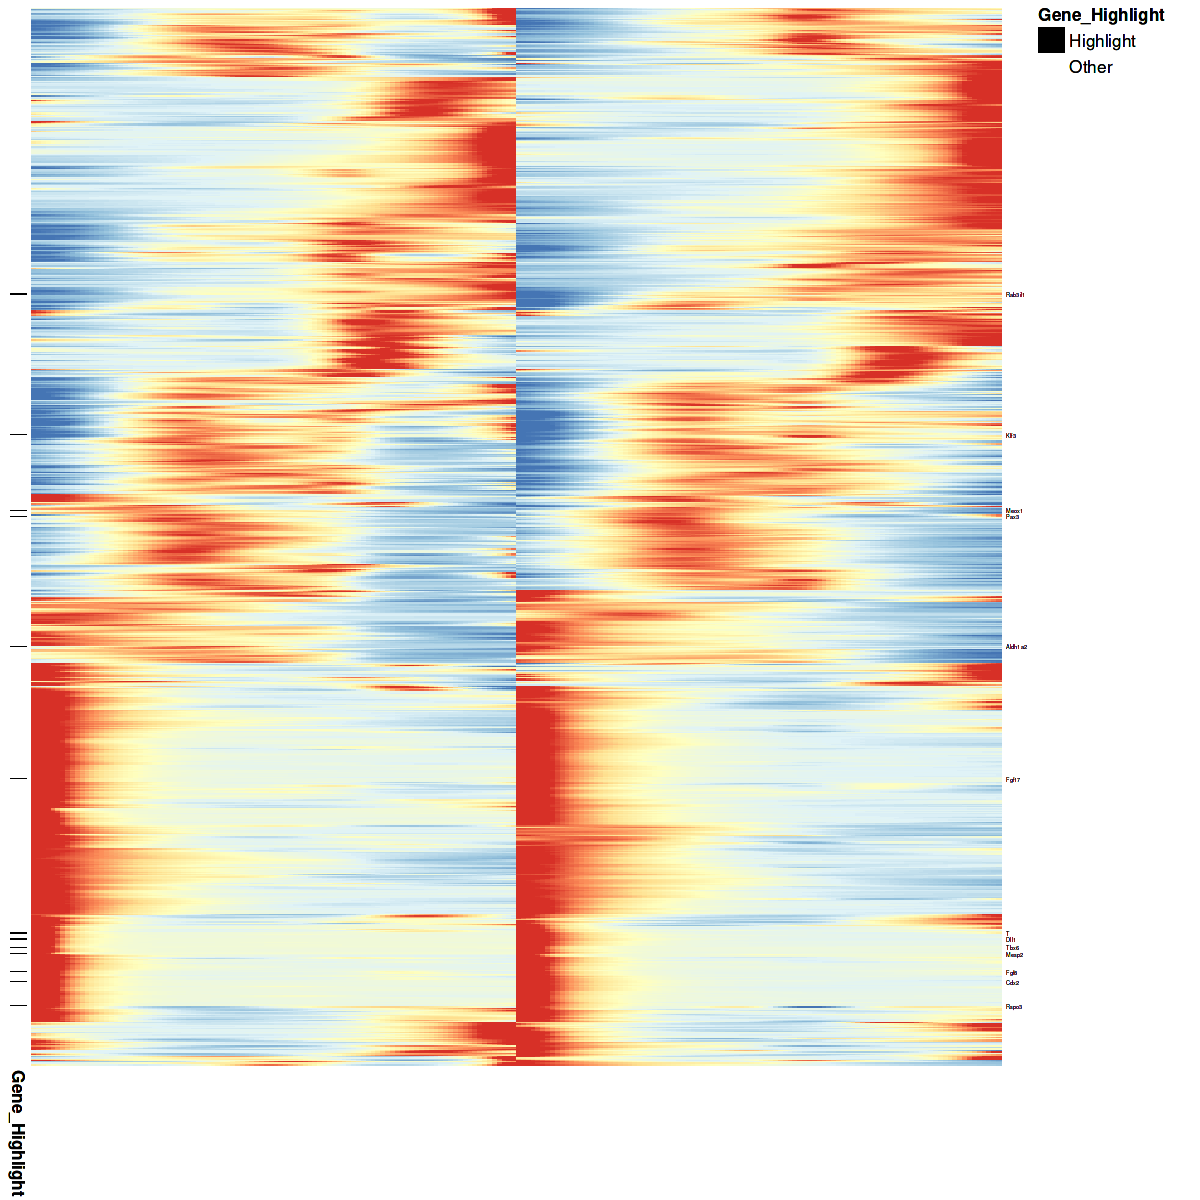

In [23]:
# Step 4: Modify the heatmap to use `row_labels` for selectively showing gene names
heatmap_plot <- pheatmap(ysmooth_scaled,
                         cluster_rows = TRUE,  
                         cluster_cols = FALSE,  
                         border_color = NA,
                         legend = FALSE,
                         display_numbers = FALSE,
                         breaks = seq(-2, 2, length.out = 101),
                         show_colnames = FALSE,
                         labels_row = row_labels,  # Use row_labels to selectively show gene names
                         annotation_row = highlight_annotation,  # Add annotation for highlighting rows
                         annotation_colors = list(Gene_Highlight = c("Highlight" = "black", "Other" = "white")),  # Color the highlighted rows in red
                         fontsize_row = 3,
                         treeheight_row = 0  # No need for tree height if no clusters are cut
                        )

# Display the heatmap_plot
wi <- 10
he <- 10

options(repr.plot.width=wi, repr.plot.height=he)
heatmap_plot 

# set the output directory
output_dir = "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_4_Tradeseq/"

# set the filename
    file_name <- paste0("tradeseq_AP","heatmap","somitic_tissues",
                       ".pdf")

# Save the grid plot as .svg file to specific file path
 ggsave(filename = file.path(output_dir, file_name), plot = heatmap_plot, device = "pdf",
      width = wi,
      height = he)

png 
  2

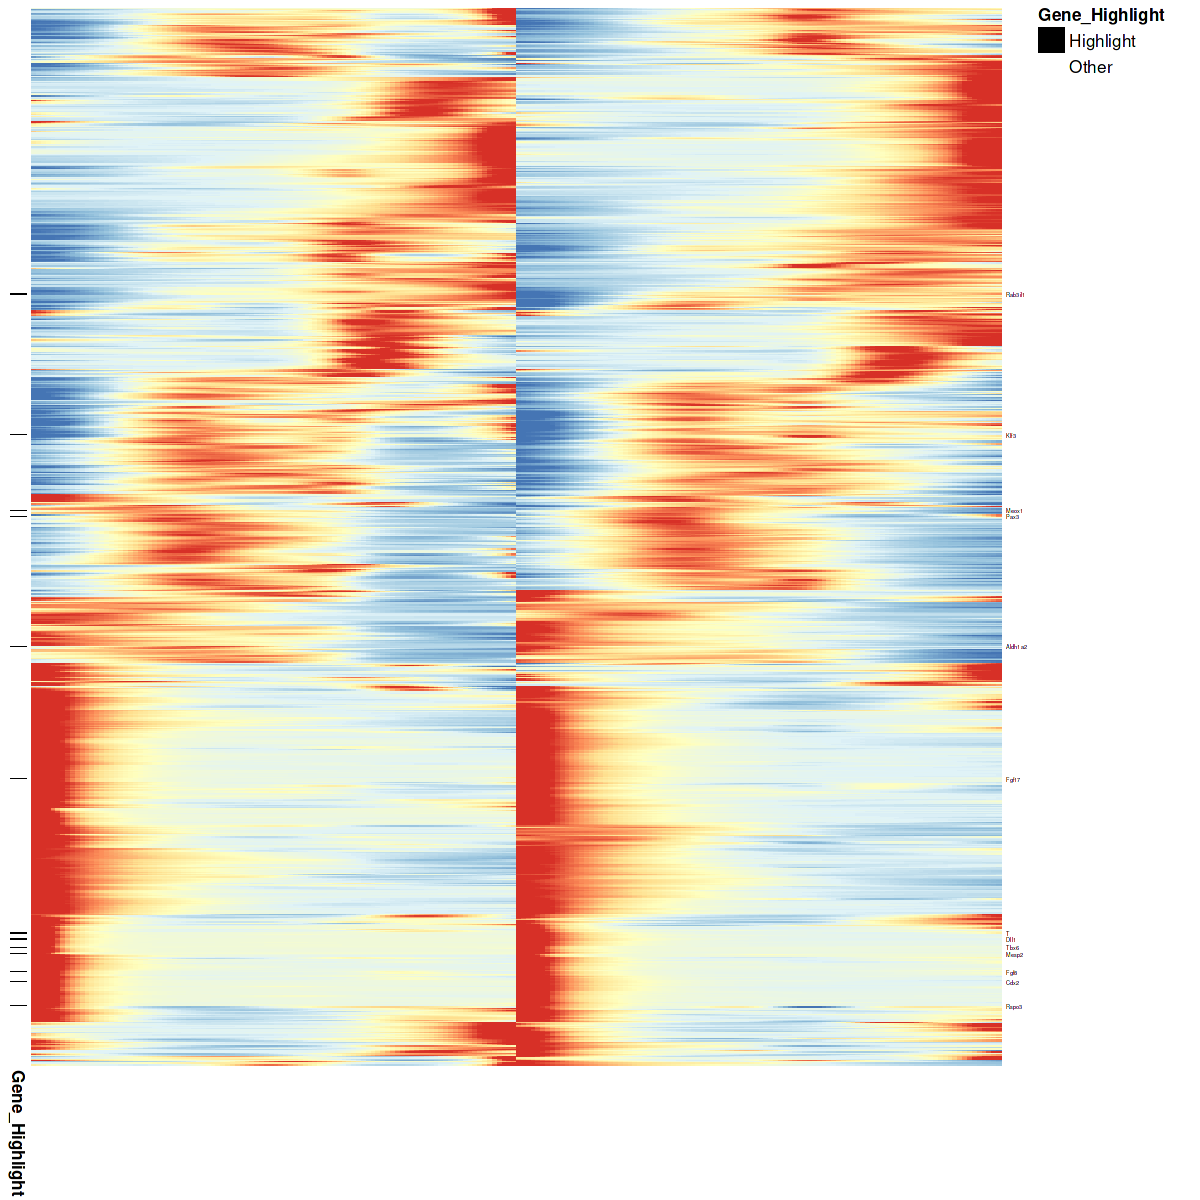

In [24]:
library(pheatmap)
library(grid)

# Create the pheatmap and store as a grob
heatmap_grob <- pheatmap(ysmooth_scaled,
                         cluster_rows = TRUE,  
                         cluster_cols = FALSE,  
                         border_color = NA,
                         legend = FALSE,
                         display_numbers = FALSE,
                         breaks = seq(-2, 2, length.out = 101),
                         show_colnames = FALSE,
                         labels_row = row_labels,
                         annotation_row = highlight_annotation,
                         annotation_colors = list(Gene_Highlight = c("Highlight" = "black", "Other" = "white")),
                         fontsize_row = 3,
                         treeheight_row = 0)

# Set output path
output_file <- file.path(output_dir, paste0("tradeseq_AP_heatmap_somitic_tissues_raster.pdf"))

# Open PDF device
pdf(output_file, width = wi, height = he, useDingbats = FALSE)
grid::grid.draw(heatmap_grob$gtable)
dev.off()

In [25]:
png(filename = file.path(output_dir, "tradeseq_AP_heatmap_somitic_tissues.png"),
    width = wi, height = he, units = "in", res = 300)
grid::grid.draw(heatmap_grob$gtable)
dev.off()

png 
  2